In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table

In [2]:
# Read the table
t1 = Table.read('TgasxWrightx2mass.vot',format='votable')
print(t1.colnames)
Source = t1["Source"]
Gmags = t1["__Gmag_"]
Vmags = t1["VTmag"]
Jmags = t1["Jmag"]
Hmags = t1["Hmag"]
Kmags = t1["Kmag"]
QFlags = t1["Qfl"]
DistW = t1["Dist"]
d1 = t1["d_arcsec"]
d2 = t1["d_arcsec_2"]
print("Finished reading Table. Read ",len(Jmags)," sources")

WARNING

['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Mag', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']
Finished reading Table. Read  28815  sources


: W33: TgasxWrightx2mass.vot:9:0: W33: Column name 'd_arcsec' renamed to 'd_arcsec 2' to ensure uniqueness [astropy.io.votable.tree]


First we will remove stars from the Wright catalog with Spectral matches that were further away from the Tycho/Hipp position by more than 4". To do this we will flag the relevant rows. This is a bit tricky...

In [3]:
for i in range(0,len(DistW)):
    if(DistW[i] > 4.0):
        row = t1[i]
        idx = row._index
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
for i in range(0,len(DistW)):
    if(DistW[i] > 4.0):
        print(i,DistW[i])
print("Finished masking rows with >4 arcsec matches in Wright et al")
test = DistW.compressed()
print("   Remaining number of sources: ",len(test))

Finished masking rows with >4 arcsec matches in Wright et al
   Remaining number of sources:  28809


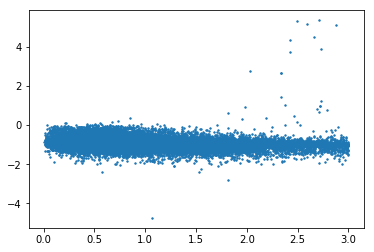

-0.909734154257
0.261953849696


In [4]:
JmG = Jmags - Gmags
plt.scatter(d1,JmG,s=2.0)
plt.show()
print(np.mean(JmG))
print(np.std(JmG))

So, there are more sources at large match radii that have large J-G than at small radii, but there are still  dominantly sources with "good" matches in J-G at large radii. So limiting the match radius to less that 3", I will do a cut on J-G using the mean and sigma above.

 Masked  30  rows based on J-G color > 5 sigma from mean


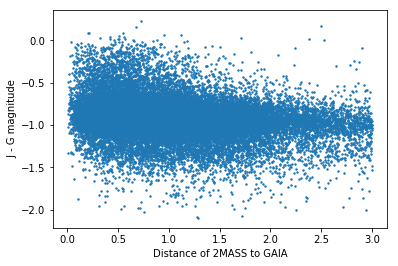

New sigma for J-G:  0.237178699483


In [5]:
imask = 0
for i in range(0,len(JmG)):
    if(abs(JmG[i] + 0.91) > 1.20):
        imask = imask + 1
        row = t1[i]
        idx = row._index
        cols = row._table.columns.values()
        for col in cols:
            col.mask[i] = True
print(" Masked ",imask," rows based on J-G color > 5 sigma from mean")
JmG = Jmags - Gmags
plt.xlabel("Distance of 2MASS to GAIA")
plt.ylabel(" J - G magnitude")
plt.scatter(d1,JmG,s=2.0)
plt.show()
print("New sigma for J-G: ",np.std(JmG))

Look at the number of duplicate matches --- places were one than 1 GAIA source matches with a 2MASS source or where 1 2MASS source matches with more than one GAIA source

In [6]:
Test = Source.compressed()
unique = set()
Gdups = set()

for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("GAIA Duplicate Source: ",Test[i])
        Gdups.add(Test[i])
    else:
        unique.add(Test[i])
        last = Test[i]
print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        Name = Source[i]
        if(Name in Gdups):
            row = t1[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
print("Finished masking all GAIA duplicates. All sources involved")
TwoM = t1["_2MASS"]
unique = set()
Tdups = set()
Test = TwoM.compressed()
for i in range(0,len(Test)):
    if(Test[i] in unique):
        print("2MASS Duplicate Source: ",Test[i])
        Tdups.add(Test[i])
    else:
        unique.add(Test[i])
        last = Test[i]
print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

for i in range(0,len(Source)):
    if(Source.mask[i] == False):
        Name = Source[i]
        if(Name in Tdups):
            print(Source[i],d1[i],d2[i],Gmags[i],Vmags[i]-Gmags[i],Jmags[i],Kmags[i],TwoM[i])

GAIA Duplicate Source:  3493889374843037056
GAIA Duplicate Source:  3671423188052818432
GAIA Duplicate Source:  3679803150283421824
GAIA Duplicate Source:  3691443439368436224
GAIA Duplicate Source:  5045205139519618816
GAIA Duplicate Source:  2921037357140599680
GAIA Duplicate Source:  1730081237068994688
GAIA Duplicate Source:  1103742376721369728
GAIA Duplicate Source:  4392970203357519360
GAIA Duplicate Source:  4410089152725531776
GAIA Duplicate Source:  6463958147354408320
GAIA Duplicate Source:  3568160388866378496
GAIA Duplicate Source:  2495889539626187264
GAIA Duplicate Source:  3572250503402231296
GAIA Duplicate Source:  3572250503402231296
GAIA Duplicate Source:  1214512606941823360
GAIA Duplicate Source:  342510928752813184
GAIA Duplicate Source:  350516782152418688
GAIA Duplicate Source:  4509228611513985152
GAIA Duplicate Source:  6608821072056229504
GAIA Duplicate Source:  5095980792648067840
GAIA Duplicate Source:  5103600030271425792
GAIA Duplicate Source:  2981630480

Let's mask the 2MASS magnitudes that are really upper limites. We can do this using the Qfl value. It is a three letter code; one letter for each band: J, H,K. "A" is the best detection and "F is the worst. "U" means that there was no detection and the value is actually an upper limit. We will mask the J, H, K magnitude arrays according to the flags for each band with
D, E, F, and U masked.

Remember since I have done no arithematic with Jmags, Hmags, and Kmags, they are just pointers to the original table so I have actually masked the values in the table. If you were to pull out "Jmag" from the table again, it would now be flagged. The only way to go back to the original non-masked state is to read in the table again. I have done it this way on purpose.

In [7]:
# Use the 2MASS flags to mask the J, H, K magnitudes which are upper limits, or poor detections.
#   U = undetected, F, E, and D are poor detections

#for i in range(0,len(QFlags)):
#    if(QFlags[i][0] == ord("U")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("U")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("U")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("F")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("F")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("F")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("E")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("E")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("E")):
#        Kmags.mask[i] = True
#    if(QFlags[i][0] == ord("D")):
#        Jmags.mask[i] = True
#    if(QFlags[i][1] == ord("D")):
#        Hmags.mask[i] = True
#    if(QFlags[i][2] == ord("D")):
#        Kmags.mask[i] = True

# Or if you only want to keep the stars with "AAA" for their flags
for i in range(0,len(QFlags)):
    if(Source.mask[i] == False):
        if(QFlags[i][0] == ord("A")):
            Jmags.mask[i] = False
        else:
            Jmags.mask[i] = True
        if(QFlags[i][1] == ord("A")):
            Hmags.mask[i] = False
        else:
            Hmags.mask[i] = True
        if(QFlags[i][2] == ord("A")):
            Kmags.mask[i] = False
        else:
            Kmags.mask[i] = True
            
        if(Jmags[i] > 10.5):
            Jmags.mask[i] = True
        if(Hmags[i] > 10.5):
            Hmags.mask[i] = True
        if(Kmags[i] > 10.5):
            Kmags.mask[i] = True
            
print("Ended Flagging of 2MASS J, H, K magnitudes")


Ended Flagging of 2MASS J, H, K magnitudes


Now lets look a J, H, K magnitude-magnitude diagrams and the color-color diagram to see how much better they look with the upper limits all removed for plotting.

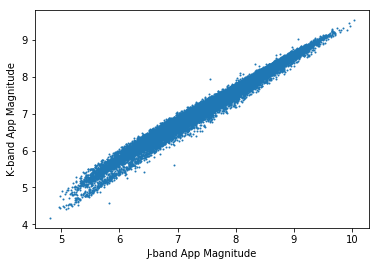

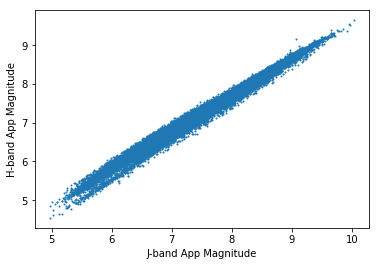

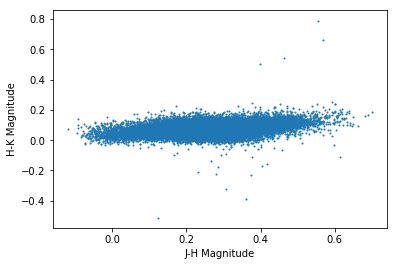

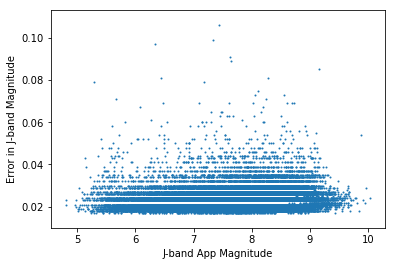

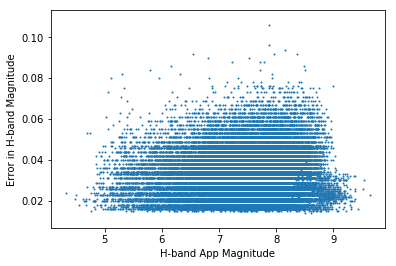

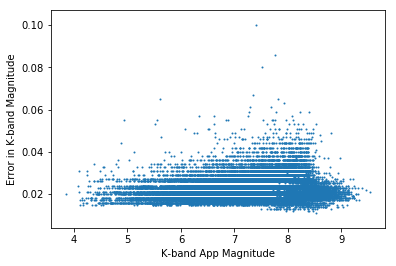

In [8]:
plt.xlabel("J-band App Magnitude")
plt.ylabel("K-band App Magnitude")
plt.scatter(Jmags,Kmags,s=1.0)
plt.show()
plt.xlabel("J-band App Magnitude")
plt.ylabel("H-band App Magnitude")
plt.scatter(Jmags,Hmags,s=1.0)
plt.show()
JmH = Jmags-Hmags
HmK = Hmags-Kmags
# plt.xlim(-1.,1.)
# plt.ylim(-1.,1.)
plt.xlabel("J-H Magnitude")
plt.ylabel("H-K Magnitude")
plt.scatter(JmH,HmK,s=1.0)
plt.show()
eJmags = t1["e_Jmag"]
eHmags = t1["e_Hmag"]
eKmags = t1["e_Kmag"]
plt.xlabel("J-band App Magnitude")
plt.ylabel("Error in J-band Magnitude")
plt.scatter(Jmags,eJmags,s=1.0)
plt.show()
plt.xlabel("H-band App Magnitude")
plt.ylabel("Error in H-band Magnitude")
plt.scatter(Hmags,eHmags,s=1.0)
plt.show()
plt.xlabel("K-band App Magnitude")
plt.ylabel("Error in K-band Magnitude")
plt.scatter(Kmags,eKmags,s=1.0)
plt.show()

Luminosity Class is often but not always given in the Wright et al Spectral Type column. The placement of the luminosity class within the spectral type is not consistent and sometimes there is more than one class (III/IV for example). There are also some that are designated as binaries with 2 spectral types given, generally with a "+" sign between then. The code below tried to deal with this by translative the ascii into a number representation for the class.
V becomes 5.0; III becomes 3.0; IV/V =4.5, etc. If there is no luminosity class given, I assigned 5.1 (assuming that it probably is V but so we can tell the difference from a real V).
Binary stars and stars with funky lumonsity/spectral designations are assigned a negative number.

In [9]:
#  Translate Spectra Type luminosity class into a number from 1 to 5
#     or a negative number if it is a binary or unknown spectral type.
#     Note that many stars do not have a luminosity class. There are given 5.1.
#
SpType = t1["SpType"]
SpTypeN = [0.0]*len(SpType)
for i in range(0,len(SpType)):
    if(SpType.mask[i] == False):
        SpT = SpType[i].decode()
        if(len(SpT) > 2):
            for j in range(0,len(SpT)):
                if(SpT[j] == 'I'):
                    SpTypeN[i] = SpTypeN[i] + 1
                if(SpT[j] == 'V'):
                    SpTypeN[i] = SpTypeN[i] + 5
                if(SpT[j] == '+'):
                    SpTypeN[i] = -20.
                
        else:
            SpTypeN[i] = 5.1
        
        if(SpTypeN[i] == 6):
            SpTypeN[i] = 4.
        if(SpTypeN[i] == 11):
            SpTypeN[i] = 4.5
        if(SpTypeN[i] == 9):
            SpTypeN[i] = 3.5
        if(SpTypeN[i] > 5.2):
            SpTypeN[i] = -30.
print("Finished Luminosity Class Translation")
count = 0
for i in range(0,len(SpType)):
    if(SpTypeN[i] < 0.):
        count = count + 1
test = SpType.compressed()
good = len(test) - count
print("  Number of single Stars: ",good,"  Binaries or Unknown luminosity class: ",count)


Finished Luminosity Class Translation
  Number of single Stars:  28354   Binaries or Unknown luminosity class:  308


In [10]:
print(SpTypeN[0:30])

[4.0, 5.0, 5.1, 5.1, 4.5, 5.0, 5.1, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.1, 5.0, 5.0, 5.1, 5.1, 3.0, 5.1, 5.0, 5.0, 5.0, 5.1, -20.0, 5.1, 4.0, 5.0, 5.0, 5.1]


C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\lgm\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


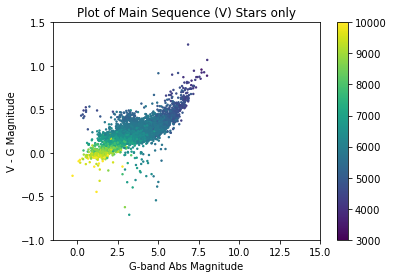

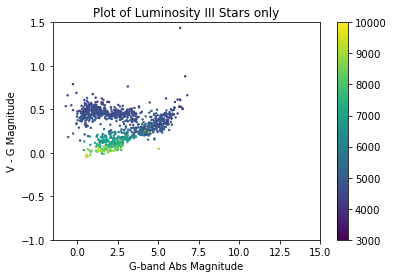

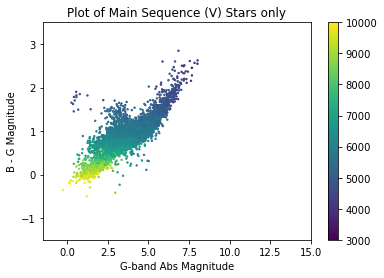

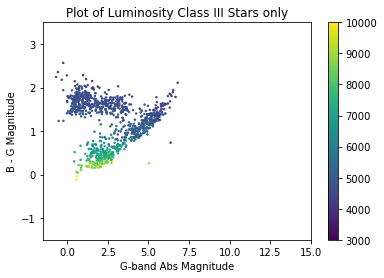

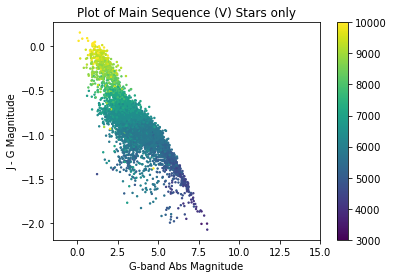

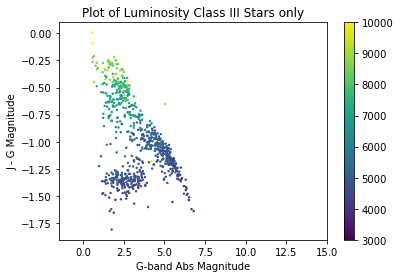

In [18]:
Dist = 1000./t1["Plx"]
Vmags = t1['VTmag'] + 5 - 5*np.log10(Dist)
Bmags = t1['BTmag'] + 5 - 5*np.log10(Dist)
Gmags = t1['__Gmag_'] + 5 - 5*np.log10(Dist)
Jmags = t1['Jmag'] + 5 - 5 * np.log10(Dist)
Hmags = t1['Hmag'] + 5 - 5 * np.log10(Dist)
Kmags = t1['Kmag'] + 5 - 5 * np.log10(Dist)
Teff = t1["Teff"]
VmG = Vmags - Gmags
BmG = Bmags - Gmags
JmG = Jmags - Gmags
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.xlim(-1.5,15)
plt.ylim(-1.0,1.5)
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.xlim(-1.5,15)
plt.ylim(-1.0,1.5)
plt.title("Plot of Luminosity III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.5,15.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Luminosity Class III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.5,15.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()

for i in range(0,len(JmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        JmG.mask[i] = False
        if(Jmags.mask[i] == True):
            JmG.mask[i] = True
    else:
        JmG.mask[i] = True
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("J - G Magnitude")
plt.xlim(-1.5,15.)
#plt.ylim(-1.0,3.0)
plt.scatter(Gmags,JmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()
for i in range(0,len(JmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        JmG.mask[i] = False
        if(Jmags.mask[i] == True):
            JmG.mask[i] = True
    else:
        JmG.mask[i] = True
plt.title("Plot of Luminosity Class III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("J - G Magnitude")
plt.xlim(-1.5,15.)
#plt.ylim(-1.0,3.0)
plt.scatter(Gmags,JmG,s=2.0,c=Teff,vmin=3000,vmax=10000)
plt.colorbar()
plt.show()

[3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


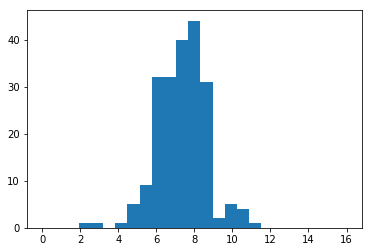

Number of stars in Teff= 3500 - 3999 : 208
     Median value:  7.32396
     Variance:      1.28641


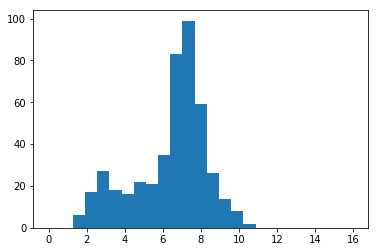

Number of stars in Teff= 4000 - 4499 : 453
     Median value:  6.4144
     Variance:      1.92388


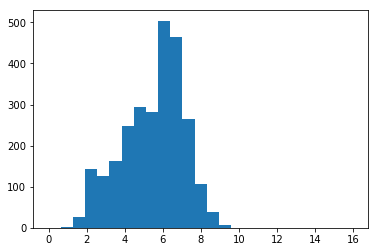

Number of stars in Teff= 4500 - 4999 : 2670
     Median value:  5.49076
     Variance:      1.61465


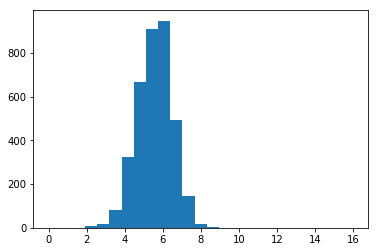

Number of stars in Teff= 5000 - 5499 : 3620
     Median value:  5.58274
     Variance:      0.912298


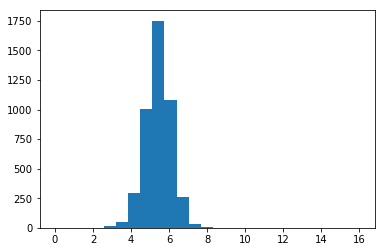

Number of stars in Teff= 5500 - 5999 : 4498
     Median value:  5.42452
     Variance:      0.671748


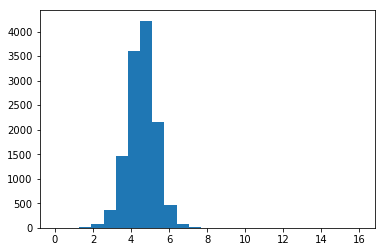

Number of stars in Teff= 6000 - 6499 : 12440
     Median value:  4.56318
     Variance:      0.730527


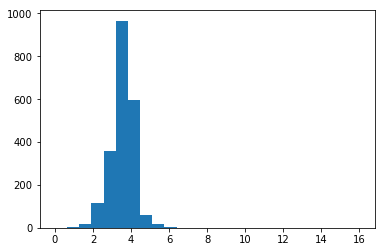

Number of stars in Teff= 6500 - 6999 : 2140
     Median value:  3.55694
     Variance:      0.600013


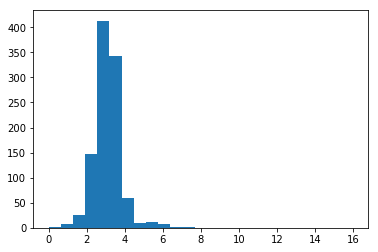

Number of stars in Teff= 7000 - 7499 : 1030
     Median value:  3.10493
     Variance:      0.720582


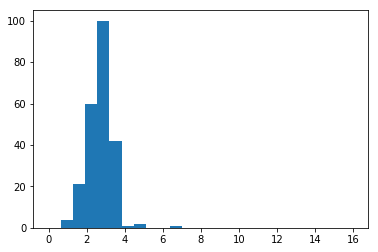

Number of stars in Teff= 7500 - 7999 : 231
     Median value:  2.70205
     Variance:      0.664291


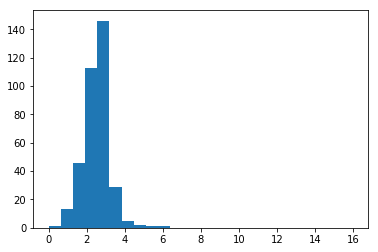

Number of stars in Teff= 8000 - 8499 : 357
     Median value:  2.5399
     Variance:      0.690068


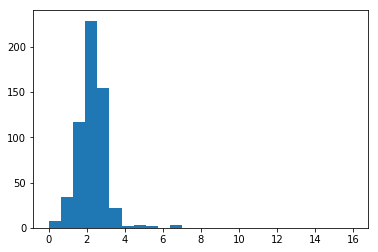

Number of stars in Teff= 8500 - 8999 : 575
     Median value:  2.29397
     Variance:      0.744295


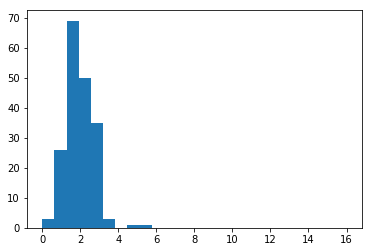

Number of stars in Teff= 9000 - 9499 : 188
     Median value:  1.9613
     Variance:      0.692306


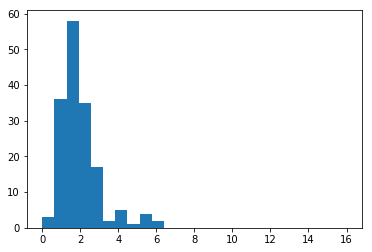

Number of stars in Teff= 9500 - 9999 : 163
     Median value:  1.97664
     Variance:      1.04007


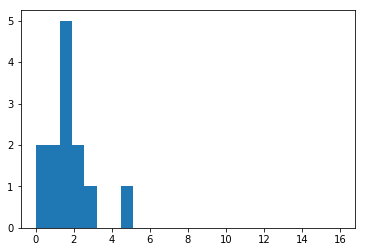

Number of stars in Teff= 10000 - 10499 : 13
     Median value:  1.81373
     Variance:      1.16154


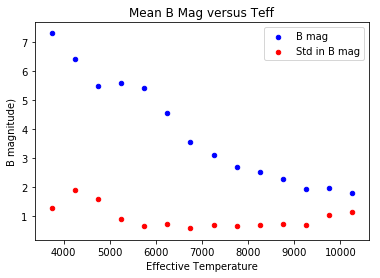

In [19]:
Teff = t1["Teff"]

temps = [3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
print(temps)
Tave = []
Bmean = []
Bstd = []

for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BMask = ma.array(Bmags,mask=TeffMask.mask)
    Bplt = ma.compressed(BMask)
    plt.hist(Bplt,bins=25,range=(0,16))
    plt.show()
    Tave.append(tmean)
    Bmean.append(np.mean(Bplt))
    Bstd.append(np.std(Bplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(Bplt))
    print("     Variance:     ",np.std(Bplt))

plt.title("Mean B Mag versus Teff")
plt.xlabel('Effective Temperature')
plt.ylabel('B magnitude)')
pllab1 = plt.scatter(Tave,Bmean,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,Bstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B mag','Std in B mag'])
plt.show()

In [48]:
eGflux = t1["e__FG_"]
Gflux = t1["__FG_"]
Gmags = t1["__Gmag_"]
for i in range(0,len(Gflux)):
    SNR = Gflux[i]/eGflux[i]
    if(SNR < 20):
        print(Gflux[i],eGflux[i],SNR, Gmags[i])
print("Finished testing G-band SNR")

4715350.45069 297926.3987 15.8272327369 8.841
470609.26764 38319.77203 12.2811082298 11.343
9454890.22577 871081.47488 10.8541973379 8.086
620078.72445 40360.92696 15.3633420031 11.044
16644155.3597 1417120.64402 11.7450517921 7.472
11712494.7108 874715.62735 13.3900599744 7.853
77333.06189 12615.8944 6.12981207975 13.304
4230130.34385 279291.46995 15.1459346202 8.959
4411172.55434 230246.49579 19.1584785654 8.913
13770167.194 876170.21459 15.7163151231 7.677
52812834.1968 3399307.1187 15.5363526603 6.218
16753852.9399 1791108.42674 9.35390213666 7.464
19073235.7548 958879.2069 19.8911767171 7.324
5539576.347 296924.21656 18.6565326708 8.666
Finished testing G-band SNR


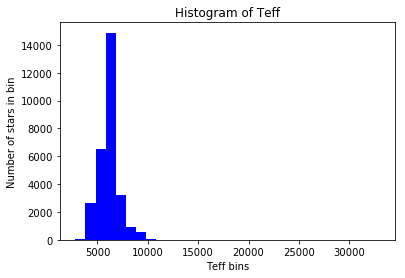

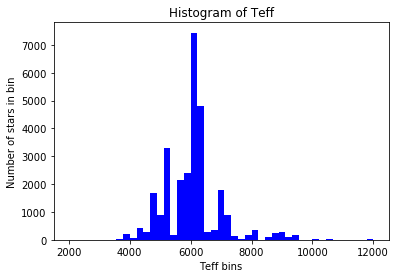

Results of number of stars in low Teff bins for TGAS x Wright et al Catalog
   Number of stars between 2000 and 2500:  0
   Number of stars between 2501 and 3000:  5
   Number of stars between 3001 and 3500:  5
   Number of stars between 3500 and 4000:  215
   Number of stars between 4001 and 4500:  446


In [13]:
plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=30,color='b')
plt.show()

plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=45,range=(2000,12000),color='b')
plt.show()

print("Results of number of stars in low Teff bins for TGAS x Wright et al Catalog")
TeffMask = ma.masked_outside(Teff,2000,2500)
print("   Number of stars between 2000 and 2500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,2501,3000)
print("   Number of stars between 2501 and 3000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3001,3500)
print("   Number of stars between 3001 and 3500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3501,4000)
print("   Number of stars between 3500 and 4000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,4001,4500)
print("   Number of stars between 4001 and 4500: ", TeffMask.count())

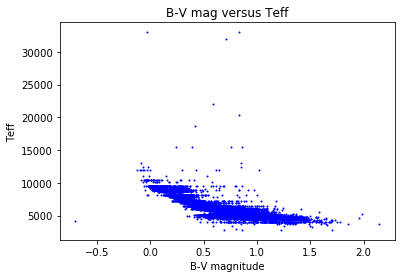

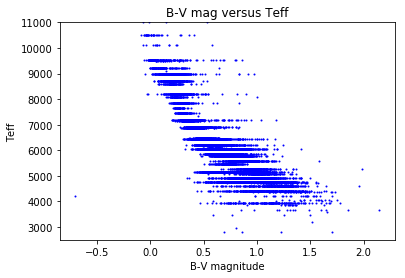

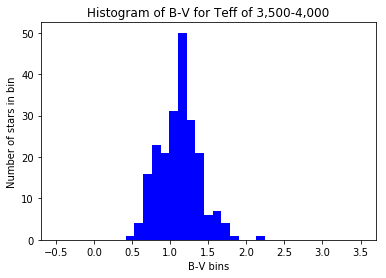

Number of stars in Teff=3,500-4,000: 215
     Median value:  1.11617
     Variance:      0.265651


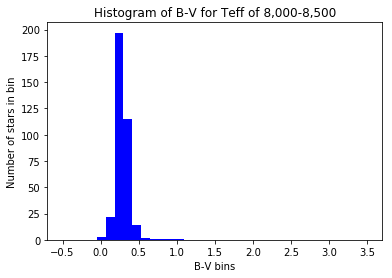

Number of stars in Teff=8,000-8,500: 357
     Median value:  0.282454
     Variance:      0.100549
[2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000]
Number of stars in Teff= 2500 - 2999 : 5
     Median value:  1.0554
     Variance:      0.368924
Number of stars in Teff= 3000 - 3499 : 5
     Median value:  1.1244
     Variance:      0.380902
Number of stars in Teff= 3500 - 3999 : 208
     Median value:  1.11209
     Variance:      0.26024
Number of stars in Teff= 4000 - 4499 : 453
     Median value:  1.12368
     Variance:      0.256079
Number of stars in Teff= 4500 - 4999 : 2670
     Median value:  0.991455
     Variance:      0.189384
Number of stars in Teff= 5000 - 5499 : 3620
     Median value:  0.804975
     Variance:      0.145613
Number of stars in Teff= 5500 - 5999 : 4498
     Median value:  0.748044
     Variance:      0.0959156
Number of stars in Teff= 6000 - 6499 : 12440
     Median value:  0.5937
   

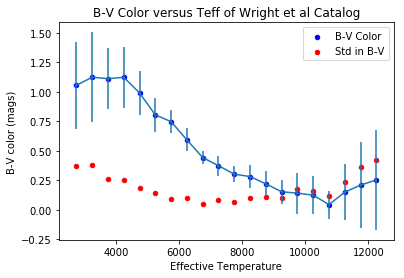

In [20]:
BmV = Bmags - Vmags
plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.ylim(2500,11000)
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

TeffMask = ma.masked_outside(Teff,3500,4000)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 3,500-4,000")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=3,500-4,000:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

TeffMask = ma.masked_outside(Teff,8000,8500)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 8,000-8,500")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=8,000-8,500:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

temps = [2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000]
print(temps)
Tave = []
BmVave = []
BmVstd = []
for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BmVMask = ma.array(BmV,mask=TeffMask.mask)
    BmVplt = BmVMask.compressed()
    Tave.append(tmean)
    BmVave.append(np.mean(BmVplt))
    BmVstd.append(np.std(BmVplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(BmVplt))
    print("     Variance:     ",np.std(BmVplt))
print(Tave)
print(BmVave)

plt.title("B-V Color versus Teff of Wright et al Catalog")
plt.xlabel('Effective Temperature')
plt.ylabel('B-V color (mags)')
pllab1 = plt.scatter(Tave,BmVave,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,BmVstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B-V Color','Std in B-V'])
plt.errorbar(Tave,BmVave,yerr=BmVstd)
plt.show()


In [39]:
BmG = Bmags - Gmags
VmG = Vmags - Gmags
JmG = Jmags - Gmags
HmG = Hmags - Gmags
KmG = Kmags - Gmags
for i in range(0,len(temps)):
    tlo = temps[i]-0.1
    thi = tlo + 500.
    TeffMask = ma.masked_outside(Teff,tlo,thi)
    print(TeffMask.count())
    BmGMask = ma.array(BmG,mask=TeffMask.mask)
    print(" Teff range: %g to %g"%(tlo,thi)," Mean: ",np.mean(BmGMask),"variance: ",np.std(BmGMask))

5
 Teff range: 2499.9 to 2999.9  Mean:  1.5595998764 variance:  0.617510709125
5
 Teff range: 2999.9 to 3499.9  Mean:  1.70579986572 variance:  0.635897976763
208
 Teff range: 3499.9 to 3999.9  Mean:  1.59167803251 variance:  0.399155832429
453
 Teff range: 3999.9 to 4499.9  Mean:  1.59917215848 variance:  0.364023375062
2670
 Teff range: 4499.9 to 4999.9  Mean:  1.37466103772 variance:  0.26973677636
3620
 Teff range: 4999.9 to 5499.9  Mean:  1.1115397585 variance:  0.201004150886
4498
 Teff range: 5499.9 to 5999.9  Mean:  1.03386220154 variance:  0.126324188403
12440
 Teff range: 5999.9 to 6499.9  Mean:  0.818604222141 variance:  0.132000393529
2140
 Teff range: 6499.9 to 6999.9  Mean:  0.608379898784 variance:  0.084301315677
1030
 Teff range: 6999.9 to 7499.9  Mean:  0.499846582505 variance:  0.133930894266
231
 Teff range: 7499.9 to 7999.9  Mean:  0.392489181452 variance:  0.105268744179
357
 Teff range: 7999.9 to 8499.9  Mean:  0.357064426112 variance:  0.14647618022
575
 Teff ra

In [151]:
for i in range(0,len(d1)):
    if(d1[i] > 2):
        print(d1[i],d2[i])

2.727261 2.816362
2.75099 2.801396
2.453678 2.173166
2.312684 1.890868
2.839039 2.512246
2.171852 0.49358
2.874345 1.684736
2.862256 0.726087
2.41057 0.856296
2.293783 0.52489
2.669909 0.78321
2.829905 0.138951
2.166649 1.201253
2.036749 1.027391
2.265292 1.346979
2.377754 0.896361
2.118781 1.628714
2.508186 2.215806
2.515703 0.617862
2.51319 2.465146
2.748069 2.80704
2.423128 2.237327
2.452749 0.698455
2.656087 1.246591
2.865767 0.992671
2.958582 0.899852
2.004838 0.010353
2.525466 0.010353
2.000778 1.9076
2.852409 1.470165
2.699456 1.66897
2.294176 1.646209
2.54321 0.976834
2.026028 1.461792
2.552889 1.387779
2.209625 0.632223
2.354705 1.741478
2.283151 0.99767
2.509385 2.350008
2.872311 2.841794
2.013875 1.426014
2.911413 0.196695
2.356412 1.878009
2.945933 2.577878
2.846874 1.812296
2.302904 0.597351
2.487098 0.265495
2.365957 1.978445
2.107273 0.698849
2.634821 0.276824
2.192944 1.828306
2.89851 0.912709
2.658795 2.178058
2.820195 2.394532
2.157421 0.918308
2.999518 0.892057
2.096

2.426631 2.332632
2.116964 1.384806
2.313191 2.235199
2.948704 1.83469
2.409805 2.47416
2.535701 2.190583
2.300284 2.277534
2.201929 0.330886
2.519099 0.929959
2.909591 2.748008
2.269602 2.029368
2.270027 1.935848
2.813855 2.463846
2.627087 0.778862
2.02591 1.916272
2.83902 0.87362
2.518567 1.701357
2.886344 2.765413
2.145688 0.919215
2.995737 2.39581
2.904822 2.527664
2.601686 0.951025
2.00657 1.792822
2.091676 2.008067
2.003297 1.886629
2.017829 1.7051
2.158098 1.156495
2.085523 2.062509
2.984024 2.667876
2.815528 2.456105
2.036267 1.744581
2.769089 0.306707
2.050468 0.92421
2.122035 1.698452
2.344486 1.111128
2.449682 0.884423
2.330344 0.945952
2.030746 0.590723
2.63127 2.017441
2.615123 2.531771
2.88603 2.463344
2.684647 0.90126
2.779644 1.10816
2.04735 1.621395
2.15015 0.94593
2.019398 1.107831
2.354836 2.021585
2.058686 2.079401
2.1994 0.209592
2.340718 1.764673
2.563202 1.298482
2.746791 1.698945
2.568306 0.396394
2.235519 1.418348
2.75708 2.505967
2.718977 2.490129
2.781518 1.8

2.65247 1.326167
2.147198 1.928991
2.663972 1.13995
2.423586 1.964512
2.434817 2.110761
2.805325 2.57039
2.552562 2.36029
2.504083 1.959398
2.548981 2.218936
2.611007 1.900003
2.194063 1.396468
2.357018 1.527045
2.038291 0.69105
2.817204 2.444782
2.841856 1.405559
2.070044 1.892933
2.628783 2.236468
2.712683 2.192939
2.834357 1.76889
2.409455 0.899708
2.184228 1.845641
2.972717 2.964337
2.11425 1.963034
2.844457 2.61643
2.113119 1.457991
2.361736 1.899812
2.262397 2.06073
2.331941 2.020533
2.283298 2.150098
2.831447 2.444728
2.23191 1.94577
2.289264 1.838697
2.665118 2.084757
2.101053 0.134142
2.661969 0.989424
2.599446 0.989926
2.206737 2.245076
2.054738 1.547124
2.801995 2.36968
2.894486 2.160024
2.413956 1.06997
2.50593 2.375596
2.609685 2.459962
2.918314 1.056801
2.93211 2.701224
2.272568 2.225976
2.839979 0.179072
2.477268 1.068717
2.3441 1.99883
2.830338 2.403999
2.060546 1.544893
2.670077 2.501505
2.584393 2.324103
2.993553 0.415304
2.289904 1.912449
2.148784 0.324955
2.641172 2

2.299346 0.239602
2.303293 0.537587
2.27566 2.349118
2.077598 0.699962
2.597632 2.495608
2.319866 0.134903
2.19853 1.630134
2.715952 1.795084
2.075202 1.420304
2.101342 0.368359
2.692555 0.362305
2.721143 2.718788
2.00455 0.878388
2.649145 2.179216
2.972092 0.203269
2.834104 0.812284
2.374978 0.572315
2.761963 1.103756
2.872267 2.84053
2.899237 1.818609
2.125743 0.808864
2.973625 2.695323
2.3469 1.891932
2.382766 0.414522
2.823038 1.677098
2.606547 0.994642
2.593528 0.403217
2.214027 0.713508
2.491257 0.196643
2.375789 0.618087
2.644982 2.030753
2.623349 1.232266
2.990628 2.118067
2.919904 2.319265
2.854187 2.203389
2.264996 2.126566
2.053917 1.90127
2.155806 0.335675
2.468216 1.84327
2.893866 0.720982
2.538099 2.355272
2.119693 0.792552
2.608336 0.2499
2.091931 1.794491
2.155515 0.257843
2.401061 0.352791
2.446893 2.218452
2.001488 1.854762
2.007699 1.235682
2.240221 1.378984
2.0863 0.468472
2.592784 0.529837
2.658417 0.080491
2.030008 1.382737
2.52841 1.763331
2.784236 2.031864
2.317

  Plx  
-------
111.235
79.2393
102.249
90.6618
111.111
109.529
66.8449
78.3085
93.8086
43.9367


  Plx  
-------
111.235
79.2393
102.249
90.6618
111.111
109.529
66.8449
78.3085
93.8086
43.9367
